# General Flow
1. Load data for life expectancy and mortality in Charleston, South Carolina. (Health metrics)
2. Run the prediciton model from Part 1 to predict the estimates for life expectancy and mortality.
3. Compare the relation among smoke estimates, mortality and life expectancy (actual and predicted) to inform citizens of Charleston about what actions to take.

In [36]:
# Load libraries
##%pip install pandas
#%pip install numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [21]:
# Load dataframe from Part 1
df_fires = pd.read_csv('df_fires.csv')

/var/folders/4g/nhvf99_175n0b7w76qwfxrkc0000gn/T/ipykernel_6015/29189048.py:1: DtypeWarning: Columns (10,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_fires = pd.read_csv('df_fires.csv')


### Loading life expectancy data

In [22]:
import os
import pandas as pd

# Initialize an empty list to store the dataframes
dataframes = []

# Path to the datasets folder
folder_path = 'datasets'

# Loop through each file in the folder
for file in os.listdir(folder_path):
    if file.endswith('.CSV'):
        # Read the file into a dataframe
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)

        # Filter the dataframe based on location, race, and sex
        filtered_df = df[(df['location_name'] == 'Charleston County (South Carolina)') & 
                         (df['race_name'] == 'Total') & 
                         (df['sex_name'] == 'Both')]

        # Group by year and calculate the average of 'val'
        average_val_per_year = filtered_df.groupby('year')['val'].mean().reset_index()

        # Append the result to the list of dataframes
        dataframes.append(average_val_per_year)

# Concatenate all the dataframes into one
final_df = pd.concat(dataframes)

In [23]:
final_df.rename(columns={'val': 'life_expectancy'}, inplace=True)


### Loading deaths due to chronic respiratory diseases (mortality)

In [24]:
# Initialize an empty list to store the dataframes
dataframes = []

# Path to the datasets folder
folder_path = 'resp_datasets'

# Loop through each file in the folder
for file in os.listdir(folder_path):
    if file.endswith('.CSV'):
        # Read the file into a dataframe
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)

        # Filter the dataframe based on location, race, and sex
        filtered_df = df[(df['location_name'] == 'Charleston County (South Carolina)') & 
                         (df['race_name'] == 'Total') & 
                         (df['sex_name'] == 'Both')]

        # Group by year and calculate the average of 'val'
        average_val_per_year = filtered_df.groupby('year')['val'].mean().reset_index()

        # Append the result to the list of dataframes
        dataframes.append(average_val_per_year)

# Concatenate all the dataframes into one
final_df_resp = pd.concat(dataframes)

In [25]:
final_df_resp.rename(columns={'val': 'mortality_respiratory_diseases'}, inplace=True)

### Combining both dataframes

In [26]:
df_new_features = pd.merge(final_df, final_df_resp, how = 'inner', on = 'year')

In [27]:
# view the new dataframe
df_new_features

,year,life_expectancy,mortality_respiratory_diseases
0,2016,41.901102,0.001320
1,2012,41.844077,0.001375
2,2004,40.149636,0.001345
3,2000,39.070426,0.001432
4,2008,41.122106,0.001412
5,2001,39.285224,0.001422
6,2005,40.284792,0.001387
7,2009,41.445454,0.001361
8,2013,41.881381,0.001396
9,2017,41.872344,0.001335


# Prediction model creation

In [28]:
#filter on the dates
df_fires = df_fires[(df_fires['fire_year'] >= 1961) & (df_fires['fire_year'] <= 2021)] #only consider fire years between 1960 and 2021

In [29]:
df_fires['discovery_date'] = pd.to_datetime(df_fires['discovery_date'], errors='coerce') #convert discovery date to datetime , discovery date was used o filter the fire seasons


In [30]:



#only take those rows where either discovery date is not there or they fall within the fire seasons i..e May 1st to Oct 31st
filter_condition = df_fires['discovery_date'].isna()

# Loop through the years to create date filters
for year in range(1961, 2022):
    start_date = pd.to_datetime(f'{year}-05-01')
    end_date = pd.to_datetime(f'{year}-10-31')
    
    # Update the filter condition to include the range for the current year
    filter_condition |= ((df_fires['discovery_date'] >= start_date) &
                         (df_fires['discovery_date'] <= end_date))

# Apply the filter to the DataFrame
filtered_df = df_fires[filter_condition]

In [31]:
filtered_df['impact_score'] = filtered_df['fire_size'] / np.log(1 + filtered_df['distance_miles'])
#average_impact_per_year = filtered_df.groupby('fire_year')['impact_score'].mean().reset_index() #get average smoke estimate per year

/var/folders/4g/nhvf99_175n0b7w76qwfxrkc0000gn/T/ipykernel_6015/2894386613.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['impact_score'] = filtered_df['fire_size'] / np.log(1 + filtered_df['distance_miles'])


In [32]:
average_impact_per_year = filtered_df.groupby('fire_year')['impact_score'].mean().reset_index() #get average smoke estimate per year

## Prediction model from Part 1

In [33]:
#%pip install statsmodels
from statsmodels.tsa.stattools import adfuller
# Perform differencing
average_impact_per_year['diff'] = average_impact_per_year['impact_score'].diff().dropna()

# Drop NaN values resulting from differencing
diff_series = average_impact_per_year['diff'].dropna()

# Re-run the ADF test on the differenced series
result_diff = adfuller(diff_series)
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value (Differenced):', result_diff[1])

ADF Statistic (Differenced): -12.799931014387626
p-value (Differenced): 6.788422450880718e-24


In [34]:
from statsmodels.tsa.arima.model import ARIMA
# Step 4: Fit the ARIMA model (adjust p, d, q as needed)
p = 2  
d = 1  # Differencing order
q = 2  

model = ARIMA(average_impact_per_year['impact_score'], order=(p, d, q))
model_fit = model.fit()

# Forecast future impact scores for 2025 to 2050
future_years = pd.date_range(start='2025', end='2051', freq='Y')
forecast_results = model_fit.get_forecast(steps=len(future_years))
forecast = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

# Prepare the forecast DataFrame
forecast_df = pd.DataFrame({
    'fire_year': future_years.year,
    'predicted_impact_score': forecast,
    'lower_bound': conf_int.iloc[:, 0],  # Lower bound of the confidence interval
    'upper_bound': conf_int.iloc[:, 1]   # Upper bound of the confidence interval
})

forecast_df.set_index('fire_year', inplace=True)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/4g/nhvf99_175n0b7w76qwfxrkc0000gn/T/ipykernel_6015/1913318272.py:11: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  future_years = pd.date_range(start='2025', end='2051', freq='Y')


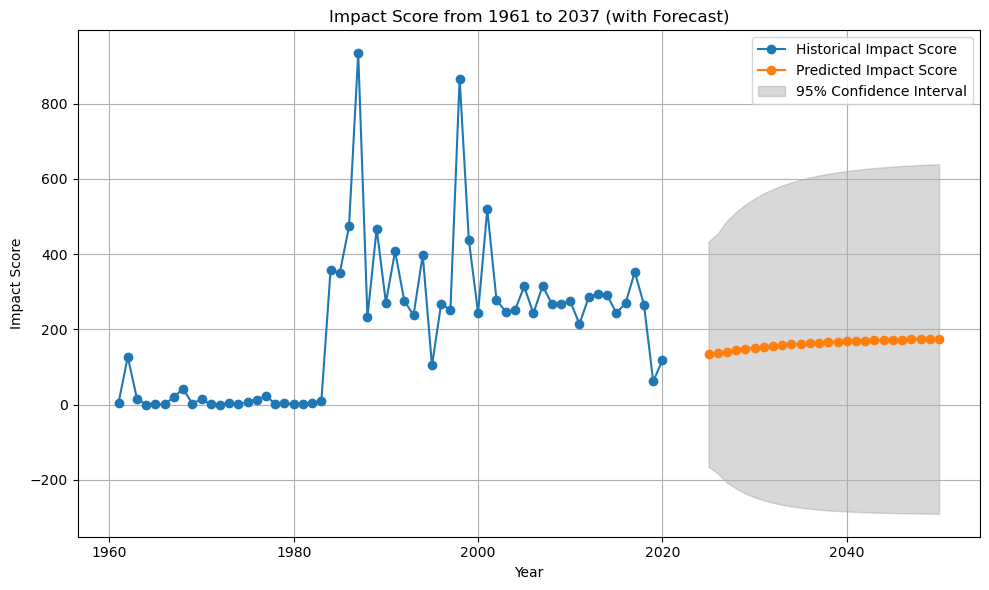

In [37]:
# Plot the historical impact score
plt.figure(figsize=(10, 6))
plt.plot(average_impact_per_year['fire_year'], average_impact_per_year['impact_score'], label='Historical Impact Score', marker='o')

# Plot the forecasted impact score with confidence intervals
plt.plot(forecast_df.index, forecast_df['predicted_impact_score'], label='Predicted Impact Score', marker='o')
plt.fill_between(forecast_df.index, forecast_df['lower_bound'], forecast_df['upper_bound'], color='gray', alpha=0.3, label='95% Confidence Interval')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Impact Score')
plt.title('Impact Score from 1961 to 2037 (with Forecast)')
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

### New Prediction model i..e Prediction model for prediciitng mortality and life expectancy

In [38]:

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Assuming df_new_features is already defined as shown

# Step 1: Fit ARIMA model for Life Expectancy
# Sort by year for time-series analysis
df_new_features = df_new_features.sort_values('year')

# Perform differencing for life expectancy
df_new_features['life_expectancy_diff'] = df_new_features['life_expectancy'].diff().dropna()

# Drop NaN values resulting from differencing
life_expectancy_diff_series = df_new_features['life_expectancy_diff'].dropna()

# Perform the ADF test on the differenced series
result_life_exp_diff = adfuller(life_expectancy_diff_series)
print('ADF Statistic (Life Expectancy Differenced):', result_life_exp_diff[0])
print('p-value (Life Expectancy Differenced):', result_life_exp_diff[1])

# Fit the ARIMA model for life expectancy
p = 2  # Adjust as needed
d = 1  # Differencing order
q = 2 # Adjust as needed

model_life_exp = ARIMA(df_new_features['life_expectancy'], order=(p, d, q))
model_life_exp_fit = model_life_exp.fit()

# Forecast future life expectancy from 2025 to 2050
future_years = pd.date_range(start='2019', end='2051', freq='Y')
forecast_results_life_exp = model_life_exp_fit.get_forecast(steps=len(future_years))
forecast_life_exp = forecast_results_life_exp.predicted_mean
conf_int_life_exp = forecast_results_life_exp.conf_int()

# Prepare the life expectancy forecast DataFrame
forecast_life_exp_df = pd.DataFrame({
    'year': future_years.year,
    'predicted_life_expectancy': forecast_life_exp,
    'life_expectancy_lower_bound': conf_int_life_exp.iloc[:, 0],  # Lower bound of the confidence interval
    'life_expectancy_upper_bound': conf_int_life_exp.iloc[:, 1]   # Upper bound of the confidence interval
})

# Step 2: Fit ARIMA model for Mortality from Respiratory Diseases

# Perform differencing for mortality
df_new_features['mortality_diff'] = df_new_features['mortality_respiratory_diseases'].diff().dropna()

# Drop NaN values resulting from differencing
mortality_diff_series = df_new_features['mortality_diff'].dropna()

# Perform the ADF test on the differenced series
result_mortality_diff = adfuller(mortality_diff_series)
print('ADF Statistic (Mortality Differenced):', result_mortality_diff[0])
print('p-value (Mortality Differenced):', result_mortality_diff[1])

# Fit the ARIMA model for mortality
model_mortality = ARIMA(df_new_features['mortality_respiratory_diseases'], order=(p, d, q))
model_mortality_fit = model_mortality.fit()

# Forecast future mortality from 2025 to 2050
forecast_results_mortality = model_mortality_fit.get_forecast(steps=len(future_years))
forecast_mortality = forecast_results_mortality.predicted_mean
conf_int_mortality = forecast_results_mortality.conf_int()

# Prepare the mortality forecast DataFrame
forecast_mortality_df = pd.DataFrame({
    'year': future_years.year,
    'predicted_mortality': forecast_mortality,
    'mortality_lower_bound': conf_int_mortality.iloc[:, 0],  # Lower bound of the confidence interval
    'mortality_upper_bound': conf_int_mortality.iloc[:, 1]   # Upper bound of the confidence interval
})

# Step 3: Combine both forecasts into a single DataFrame

combined_forecast_df = pd.merge(forecast_life_exp_df, forecast_mortality_df, on='year')


ADF Statistic (Life Expectancy Differenced): -4.509662843714493
p-value (Life Expectancy Differenced): 0.00018888378128625896
ADF Statistic (Mortality Differenced): -6.349301467481601
p-value (Mortality Differenced): 2.6350086375926456e-08


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/4g/nhvf99_175n0b7w76qwfxrkc0000gn/T/ipykernel_6015/325481283.py:31: FutureWarning: 'Y' is deprecated and will be removed in a future version, p

In [39]:
combined_forecast_df.head()

,year,predicted_life_expectancy,life_expectancy_lower_bound,life_expectancy_upper_bound,predicted_mortality,mortality_lower_bound,mortality_upper_bound
0,2019,42.347510,42.145790,42.549229,0.001282,0.001205,0.001358
1,2020,42.625881,42.327816,42.923945,0.001272,0.001192,0.001352
2,2021,42.891892,42.401390,43.382393,0.001256,0.001169,0.001342
3,2022,43.122837,42.376506,43.869167,0.001274,0.001171,0.001377
4,2023,43.319496,42.286390,44.352603,0.001267,0.001158,0.001376


### View Prediction model outputs for Life expectancy and mortality

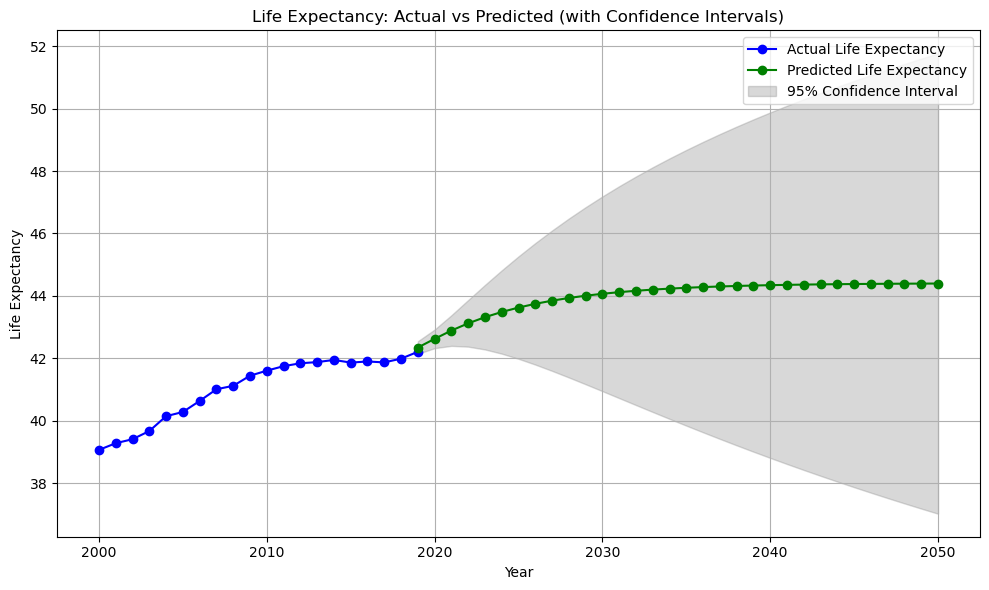

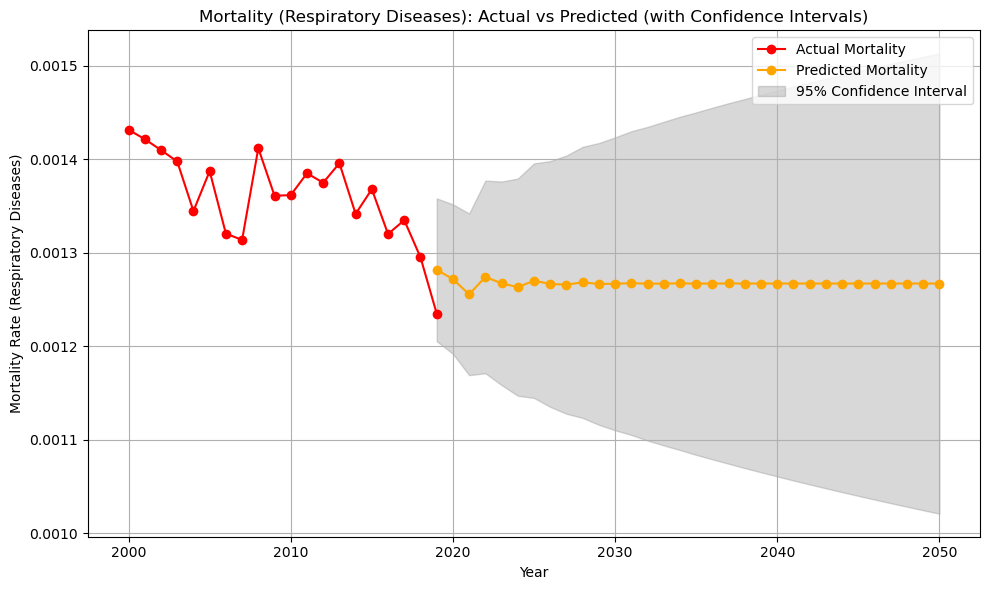

In [40]:
plt.figure(figsize=(10, 6))

# Plot the actual life expectancy data
plt.plot(df_new_features['year'], df_new_features['life_expectancy'], label='Actual Life Expectancy', marker='o', color='blue')

# Plot the predicted life expectancy data
plt.plot(forecast_life_exp_df['year'], forecast_life_exp_df['predicted_life_expectancy'], label='Predicted Life Expectancy', marker='o', color='green')

# Plot the confidence interval for the predictions
plt.fill_between(forecast_life_exp_df['year'], 
                 forecast_life_exp_df['life_expectancy_lower_bound'], 
                 forecast_life_exp_df['life_expectancy_upper_bound'], 
                 color='gray', alpha=0.3, label='95% Confidence Interval')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Life Expectancy')
plt.title('Life Expectancy: Actual vs Predicted (with Confidence Intervals)')
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot for Mortality Due to Respiratory Diseases

plt.figure(figsize=(10, 6))

# Plot the actual mortality data
plt.plot(df_new_features['year'], df_new_features['mortality_respiratory_diseases'], label='Actual Mortality', marker='o', color='red')

# Plot the predicted mortality data
plt.plot(forecast_mortality_df['year'], forecast_mortality_df['predicted_mortality'], label='Predicted Mortality', marker='o', color='orange')

# Plot the confidence interval for the predictions
plt.fill_between(forecast_mortality_df['year'], 
                 forecast_mortality_df['mortality_lower_bound'], 
                 forecast_mortality_df['mortality_upper_bound'], 
                 color='gray', alpha=0.3, label='95% Confidence Interval')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Mortality Rate (Respiratory Diseases)')
plt.title('Mortality (Respiratory Diseases): Actual vs Predicted (with Confidence Intervals)')
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()


### Comparing actual and predicted life expectancy and mortality

Correlation between actual mortality and actual life expectancy: -0.6035919571797704
Correlation between predicted mortality and predicted life expectancy: -0.34956204324286744


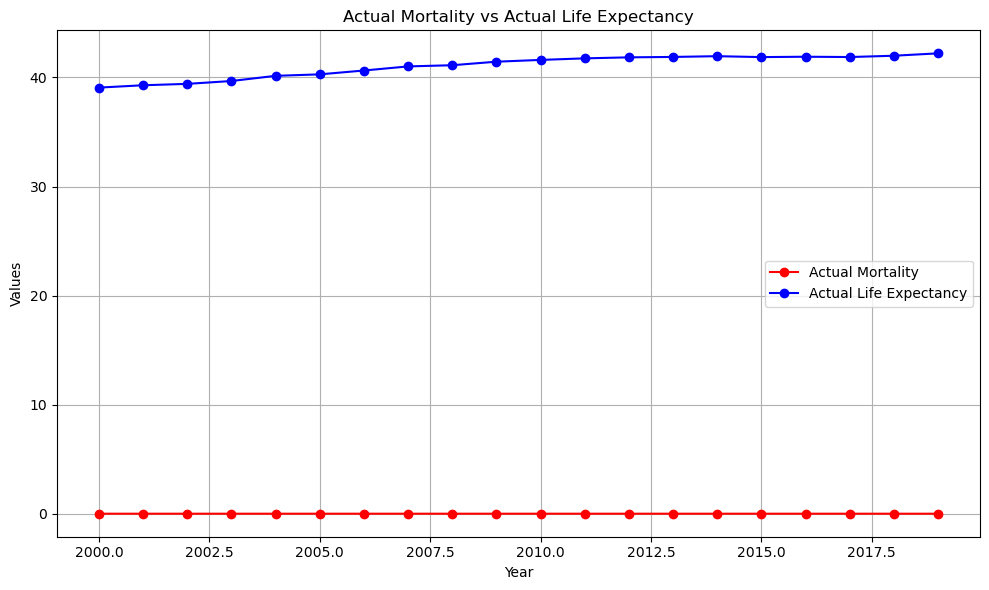

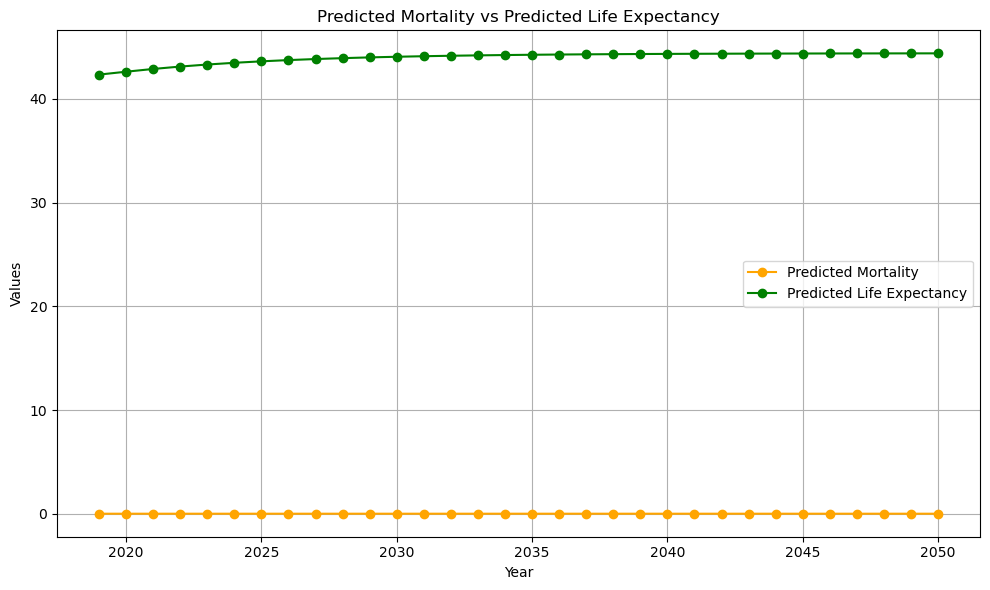

In [41]:
# Calculate the correlation coefficient between actual mortality and actual life expectancy
correlation_actual = df_new_features[['mortality_respiratory_diseases', 'life_expectancy']].corr().iloc[0, 1]

# Calculate the correlation coefficient between predicted mortality and predicted life expectancy
correlation_predicted = pd.DataFrame({
    'predicted_mortality': forecast_mortality_df['predicted_mortality'],
    'predicted_life_expectancy': forecast_life_exp_df['predicted_life_expectancy']
}).corr().iloc[0, 1]

# Print correlation coefficients
print("Correlation between actual mortality and actual life expectancy:", correlation_actual)
print("Correlation between predicted mortality and predicted life expectancy:", correlation_predicted)

# Plot 1: Actual Mortality vs Actual Life Expectancy
plt.figure(figsize=(10, 6))
plt.plot(df_new_features['year'], df_new_features['mortality_respiratory_diseases'], label='Actual Mortality', marker='o', color='red')
plt.plot(df_new_features['year'], df_new_features['life_expectancy'], label='Actual Life Expectancy', marker='o', color='blue')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Values')
plt.title('Actual Mortality vs Actual Life Expectancy')
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Predicted Mortality vs Predicted Life Expectancy
plt.figure(figsize=(10, 6))
plt.plot(forecast_mortality_df['year'], forecast_mortality_df['predicted_mortality'], label='Predicted Mortality', marker='o', color='orange')
plt.plot(forecast_life_exp_df['year'], forecast_life_exp_df['predicted_life_expectancy'], label='Predicted Life Expectancy', marker='o', color='green')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Values')
plt.title('Predicted Mortality vs Predicted Life Expectancy')
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


**As expected there is a negative relation between two.**

### Comparing actual smoke estimate, life expectancy and mortality

In [42]:

# Calculating correlation
average_impact_per_year.rename(columns={'fire_year': 'year'}, inplace=True)

# Merge the dataframes on 'year'
merged_df = pd.merge(average_impact_per_year, df_new_features, on='year', how='inner')

# Calculate correlations
correlation_impact_mortality = merged_df['impact_score'].corr(merged_df['mortality_respiratory_diseases'])
correlation_impact_life_expectancy = merged_df['impact_score'].corr(merged_df['life_expectancy'])

# Print the correlations
print(f'Correlation between smoke estimate and mortality: {correlation_impact_mortality}')
print(f'Correlation between smoke estimate and life expectancy: {correlation_impact_life_expectancy}')

Correlation between smoke estimate and mortality: 0.4947584341961076
Correlation between smoke estimate and life expectancy: -0.3536624667580646


**As expected there is a negative relation between smoke and life expectancy; positive between smoke and mortality.**

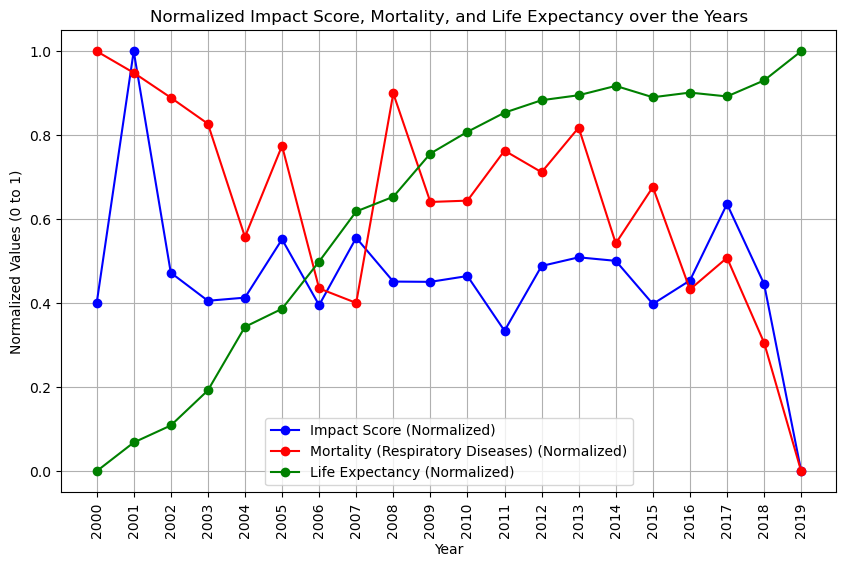

In [44]:
# Visualizing the realtionship, but normalizing so that all three come to the same scale.

from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Select the columns to normalize and apply MinMaxScaler
columns_to_normalize = ['impact_score', 'mortality_respiratory_diseases', 'life_expectancy']
normalized_values = scaler.fit_transform(merged_df[columns_to_normalize])

# Create a new DataFrame for normalized values
normalized_df = pd.DataFrame(normalized_values, columns=columns_to_normalize)
normalized_df['year'] = merged_df['year']

# Plot the normalized values
plt.figure(figsize=(10, 6))

# Plot normalized impact score
plt.plot(normalized_df['year'], normalized_df['impact_score'], marker='o', label='Impact Score (Normalized)', color='blue')

# Plot normalized mortality
plt.plot(normalized_df['year'], normalized_df['mortality_respiratory_diseases'], marker='o', label='Mortality (Respiratory Diseases) (Normalized)', color='red')

# Plot normalized life expectancy
plt.plot(normalized_df['year'], normalized_df['life_expectancy'], marker='o', label='Life Expectancy (Normalized)', color='green')

# Set x-axis to display whole numbers (years)
plt.xticks(normalized_df['year'], normalized_df['year'].astype(int))

# Add labels, title, and grid
plt.xlabel('Year')
plt.ylabel('Normalized Values (0 to 1)')
plt.title('Normalized Impact Score, Mortality, and Life Expectancy over the Years')
plt.grid(True)
plt.legend()
plt.xticks(rotation=90)

# Show the plot
plt.show()


### Comparing predcited smoke estimate, life expectancy and mortality

In [46]:
#.rename(columns={'fire_year': 'year'}, inplace=True)

# Merge the dataframes on 'year'
merged_df_pred = pd.merge(forecast_df, combined_forecast_df, left_on='fire_year', right_on = 'year', how='inner')


In [47]:
# Calculate correlations between predicted_impact_score and predicted_mortality
correlation_impact_mortality = merged_df_pred['predicted_impact_score'].corr(merged_df_pred['predicted_mortality'])

# Calculate correlations between predicted_impact_score and predicted_life_expectancy
correlation_impact_life_expectancy = merged_df_pred['predicted_impact_score'].corr(merged_df_pred['predicted_life_expectancy'])

# Print the correlations
print(f'Correlation between predicted impact score and predicted mortality: {correlation_impact_mortality}')
print(f'Correlation between predicted impact score and predicted life expectancy: {correlation_impact_life_expectancy}')


Correlation between predicted impact score and predicted mortality: -0.2740666683968393
Correlation between predicted impact score and predicted life expectancy: 0.9846479005957747


**Opposite to as  expected there is a positive relation between smoke and life expectancy; a negative one between smoke and mortality.**

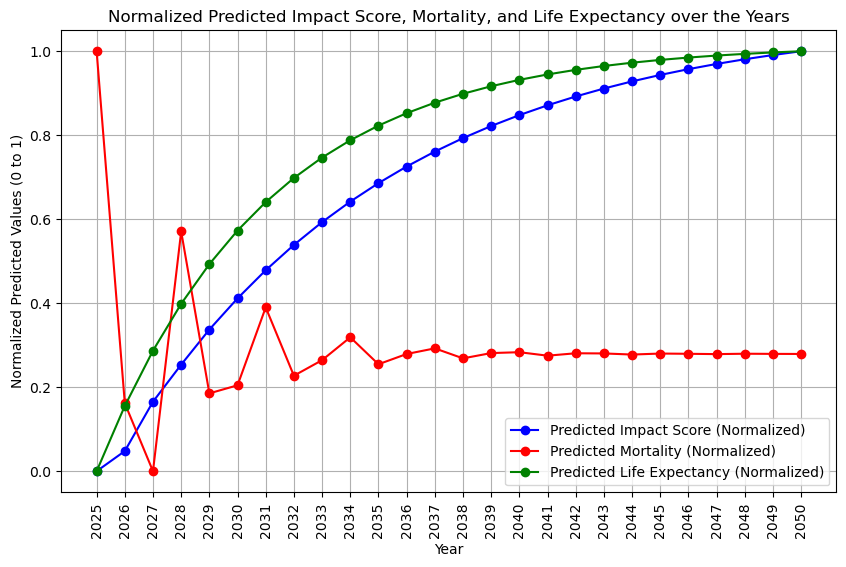

In [49]:
# Visualizing the realtionship, but normalizing so that all three come to the same scale.

from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Select the columns to normalize and apply MinMaxScaler
columns_to_normalize = ['predicted_impact_score', 'predicted_mortality', 'predicted_life_expectancy']
normalized_values = scaler.fit_transform(merged_df_pred[columns_to_normalize])

# Create a new DataFrame for normalized values
normalized_df_pred = pd.DataFrame(normalized_values, columns=columns_to_normalize)
normalized_df_pred['year'] = merged_df_pred['year']

# Plot the normalized predicted values
plt.figure(figsize=(10, 6))

# Plot normalized predicted impact score
plt.plot(normalized_df_pred['year'], normalized_df_pred['predicted_impact_score'], marker='o', label='Predicted Impact Score (Normalized)', color='blue')

# Plot normalized predicted mortality
plt.plot(normalized_df_pred['year'], normalized_df_pred['predicted_mortality'], marker='o', label='Predicted Mortality (Normalized)', color='red')

# Plot normalized predicted life expectancy
plt.plot(normalized_df_pred['year'], normalized_df_pred['predicted_life_expectancy'], marker='o', label='Predicted Life Expectancy (Normalized)', color='green')

# Set x-axis to display whole numbers (years)
plt.xticks(normalized_df_pred['year'], normalized_df_pred['year'].astype(int))

# Add labels, title, and grid
plt.xlabel('Year')
plt.ylabel('Normalized Predicted Values (0 to 1)')
plt.title('Normalized Predicted Impact Score, Mortality, and Life Expectancy over the Years')
plt.grid(True)
plt.legend()
plt.xticks(rotation=90)

# Show the plot
plt.show()


**The prediction model results seems inconclusive. This maybe due to model not fine tuned to reflect real world behaviour, less data points and causality in the features not being considered.**